# COMPSCI 682 – FINAL PROJECT
### Problem: Segmented Classification

Below **Imports**

In [1]:
import os
import PIL
import cv2

import random
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

# TORCH
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

from sklearn.cluster import KMeans


Below **Preproccess Data** 


**Step 0.1**: Preprocesses and reorganize the dataset

The dataset images are denoted as follows (*from the Dataset website*):


> *The name of the images has the following format: XXXXXX_Y.jpg. XXXXXX is the identifier of the placemark. There are total number of 10343 placemarks in this dataset, so XXXXXX ranges from 000001 to 10343.
Y is the identifier of the view. 1, 2, 3 and 4 are the side views and 5 is the upward view. 0 is the view with markers overlaid (explained above). Thus, there are total number of 6 images per placemark.*


In [2]:
from typing import DefaultDict
pitts_folder = '../data/part1'
ny_folder = '../data/part2'

cart_file = '../data/GPS_Long_Lat_Compass.mat'

coords = scipy.io.loadmat(cart_file)

def sample_dataset(dataset):
    num_instances = dataset.shape[0]
    
    rand_index = random.randint(0, num_instances)
    rand_image = dataset[rand_index]
    image = np.moveaxis(rand_image, (0, 1, 2), (2, 1, 0))
    
    print("original: ", rand_image.shape)
    print("rehsaped: ", image.shape)
    
    plt.imshow(image)
    plt.gca().axis('off')
    plt.show()

def plot_coords(coords):
    lats, lons = np.hsplit(coords, 2)
    plt.scatter(lats, lons)
    
    
def new_dataset(folders, num_instances, img_ht, img_wid, start=0):
    data_X = list() # the instance attributes    
    coordinates = list()
    
    count = 0

    for folder in folders:
        for image in os.listdir(folder):
            if not image.endswith('.jpg'): continue
            image_name = image.split(".")[0]
            view = int(image_name[-1])
            
            coordinates.append(coords['GPS_Compass'][int(image_name[:-2]) - 1][:2])
            
            img_path = os.path.join(folder, image)
            img = cv2.imread( img_path, cv2.IMREAD_COLOR)
            
            img=cv2.resize(img, (img_ht, img_wid), interpolation = cv2.INTER_AREA)
            img = img
            img = img.astype('float32')
            img /= 255 
            data_X.append(img.T)
            count += 1
    
    return np.array(data_X), np.array(coordinates)


**Data**: Pittsburg (Pt.1)

pitts (1) shape:  (6594, 3, 100, 100)
original:  (3, 100, 100)
rehsaped:  (100, 100, 3)


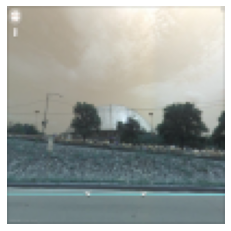

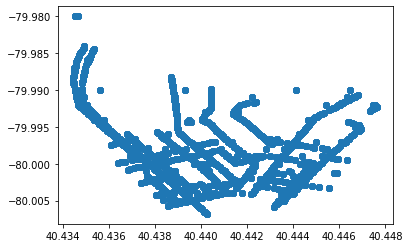

In [3]:
num_imgs = 6594
img_wid = 100
img_ht = 100
folders = [pitts_folder]
pitts_1_data, pitts_1_coords = new_dataset(folders=folders, num_instances=num_imgs, img_ht=img_ht, img_wid=img_wid )
print("pitts (1) shape: ", pitts_1_data.shape)
sample_dataset(dataset=pitts_1_data)

plot_coords(pitts_1_coords)

**Data**: Pittsburg (Pt.2)

pitts (2) shape:  (6594, 3, 100, 100)
original:  (3, 100, 100)
rehsaped:  (100, 100, 3)


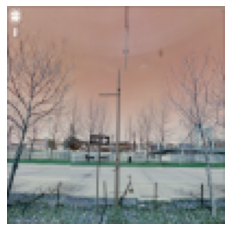

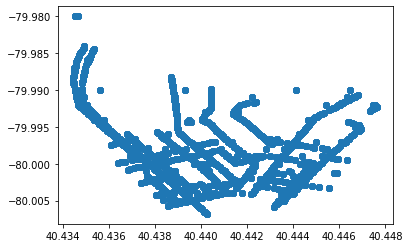

In [4]:
num_imgs = 6594
img_wid = 100
img_ht = 100
folders = [pitts_folder]
pitts_2_data, pitts_2_coords = new_dataset(folders=folders, num_instances=num_imgs, img_ht=img_ht, img_wid=img_wid )
print("pitts (2) shape: ", pitts_2_data.shape)
sample_dataset(dataset=pitts_2_data)

plot_coords(pitts_2_coords)

**Label** data by splitting with respect to **coordinates**

In [5]:
def label_data(data):
    labels = []
    for coord in data:
        if(coord[1] > -79.9999): labels.append(0)
        else: labels.append(1)
    return np.array(labels)

# COORDS are the LABELS
total_images = np.vstack((pitts_1_data, pitts_2_data))
total_coords = np.vstack((pitts_1_coords, pitts_2_coords))
total_labels = label_data(total_coords)


# CHECK LABELS
print("num on left: ", np.sum(total_labels == 0))
print("num on right: ", np.sum(total_labels == 1))

# CONVERT numpy array to TENSOR
X = total_images
y = total_labels

mean = torch.from_numpy(X).mean()
std = torch.from_numpy(X).std()
transform_norm = T.Compose([
    T.Normalize(mean, std)
])

X = transform_norm(torch.from_numpy(X))

data = []
test = []
for i in range(len(X)):
    data.append([X[i], y[i]])

# CONSTRUCT data loaders
NUM_TRAIN = int(0.80 * len(data))
NUM_TOTAL = len(data)

loader_val = DataLoader(data, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TOTAL)))
loader_train = DataLoader(data, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))


print(X.shape)

num on left:  8100
num on right:  5088
torch.Size([13188, 3, 100, 100])


**Step 2.** Build Convolutional Model


In [6]:
# We need to wrap `flatten` function in a module in order to stack it
# in nn.Sequential
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)
    
# QUICK model creation based more or less off inception
model = nn.Sequential(
            # INPUT: (3, 100, 100) 
            # CNN LAYER: 30 5x5 channels
            nn.Conv2d(in_channels=3, out_channels=30, kernel_size=5),
    
            # INPUT: (30, 94, 94)
            # MAX-POOL: 3x3 filter
            nn.MaxPool2d(kernel_size=4, stride=2), 
    
            # INPUT: (30, 45, 45)
            # CNN LAYER: 20 3x3 channels
            nn.Conv2d(in_channels=30, out_channels=20, kernel_size=4, stride=2),
    
            # INPUT: (30, 20, 20)
            # CNN LAYER: 20 3x3 channels
            nn.MaxPool2d(kernel_size=4, stride=2),
            
            # INPUT: (20, 13, 13)
            nn.Flatten(),
            nn.Linear(in_features=2000, out_features=2, bias=True),
           
        )



In [7]:
USE_GPU = True
dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
def check_accuracy_part34(loader, model):
    print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

def train_part34(model, optimizer, epochs=10, print_every=10):
    """    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    #model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part34(loader_val, model)
                print()

In [8]:
import copy
learn_rates = [0.0005]

for lr in learn_rates:

    optimizer = optim.SGD(model.parameters(), lr=lr,
                     momentum=0.9, nesterov=True)
    
    train_part34(model, optimizer, epochs=10)

/Users/stephen/miniforge3/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Iteration 0, loss = 0.7123
Checking accuracy on test set
Got 1462 / 2638 correct (55.42)

Iteration 10, loss = 0.6992
Checking accuracy on test set
Got 1569 / 2638 correct (59.48)

Iteration 20, loss = 0.7533
Checking accuracy on test set
Got 1543 / 2638 correct (58.49)

Iteration 30, loss = 0.6570
Checking accuracy on test set
Got 1555 / 2638 correct (58.95)

Iteration 40, loss = 0.6917
Checking accuracy on test set
Got 1609 / 2638 correct (60.99)

Iteration 50, loss = 0.6654
Checking accuracy on test set
Got 1628 / 2638 correct (61.71)

Iteration 60, loss = 0.6457
Checking accuracy on test set
Got 1636 / 2638 correct (62.02)

Iteration 70, loss = 0.7313
Checking accuracy on test set
Got 1617 / 2638 correct (61.30)

Iteration 80, loss = 0.6361
Checking accuracy on test set
Got 1659 / 2638 correct (62.89)

Iteration 90, loss = 0.6470
Checking accuracy on test set
Got 1652 / 2638 correct (62.62)

Iteration 100, loss = 0.6647
Checking accuracy on test set
Got 1629 / 2638 correct (61.75)


Iteration 50, loss = 0.5564
Checking accuracy on test set
Got 1816 / 2638 correct (68.84)

Iteration 60, loss = 0.5456
Checking accuracy on test set
Got 1787 / 2638 correct (67.74)

Iteration 70, loss = 0.6267
Checking accuracy on test set
Got 1795 / 2638 correct (68.04)

Iteration 80, loss = 0.5074
Checking accuracy on test set
Got 1804 / 2638 correct (68.39)

Iteration 90, loss = 0.5120
Checking accuracy on test set
Got 1801 / 2638 correct (68.27)

Iteration 100, loss = 0.5568
Checking accuracy on test set
Got 1815 / 2638 correct (68.80)

Iteration 110, loss = 0.6395
Checking accuracy on test set
Got 1814 / 2638 correct (68.76)

Iteration 120, loss = 0.5984
Checking accuracy on test set
Got 1827 / 2638 correct (69.26)

Iteration 130, loss = 0.6018
Checking accuracy on test set
Got 1832 / 2638 correct (69.45)

Iteration 140, loss = 0.6023
Checking accuracy on test set
Got 1818 / 2638 correct (68.92)

Iteration 150, loss = 0.5878
Checking accuracy on test set
Got 1847 / 2638 correct (7

In [9]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Make input tensor require gradient
    X.requires_grad_()
    
    saliency = None
    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores (we'll combine losses across a batch by summing), and then compute  #
    # the gradients with a backward pass.                                        #
    ##############################################################################
    # COMPUTE model scores 
    scores = model.forward(X)
    
    # COMPUTE the loss
    rel_scores = scores.gather(1, y.view(-1, 1)).squeeze()
    
    loss_func = nn.CrossEntropyLoss()
    loss = loss_func(scores, y)
    loss.backward()
    
    # GET X derivative
    X_derivs = X.grad
    print(X_derivs.shape)
    saliency, _ = torch.max(torch.abs(X_derivs), 1)
    print(saliency.shape)
        
    # MAP instances to CORRECT label scores
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

def show_saliency_maps(X, y):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.Tensor(X)
    y_tensor = torch.LongTensor(y)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        image = np.moveaxis(X[i], (0, 1, 2), (2, 1, 0))
        plt.imshow(image)
        plt.axis('off')
        plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 3, 100, 100)
torch.Size([4, 3, 100, 100])
torch.Size([4, 100, 100])


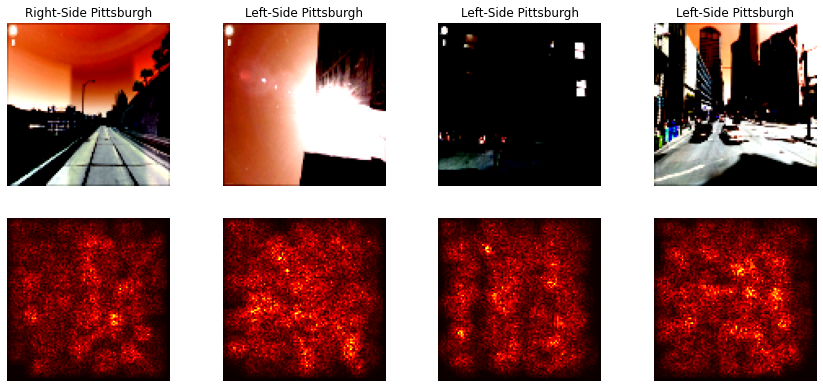

In [10]:
import random

class_names = ["Right-Side Pittsburgh","Left-Side Pittsburgh"]


def get_random_images(vis_data, num_images):
    choices = np.zeros(shape=(num_images, 3, 100, 100))
    choice_labels = np.zeros(shape=(num_images), dtype=int)
    for i in range(num_images):
        rand_index = random.randint(0, len(data))
        X, y = data[rand_index] 
        choices[i] = torch.Tensor(X)
        choice_labels[i] = y
        
    return choices, choice_labels
    
sample_X, sample_y = get_random_images(data, 4)
print(sample_X.shape)
      
plt.figure(figsize=(50, 50))
for i in range(len(sample_X)):
    plt.subplot(1, 5, i + 1)
    image = np.moveaxis(sample_X[i], (0, 1, 2), (2, 1, 0))
    plt.imshow(image)

    plt.title(class_names[sample_y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

show_saliency_maps(sample_X, sample_y)